In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import joblib
from pathlib import Path

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Define feature groups
NUMERIC_FEATURES = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'day']
CATEGORICAL_FEATURES = ['job', 'marital', 'contact', 'poutcome']
BINARY_FEATURES = ['default', 'housing', 'loan']
ORDINAL_FEATURES = ['education', 'month']
TARGET = 'y'

#EXCLUDED FEATURES
EXCLUDE_FEATURES = []

In [8]:
# Data Dictionary 
# ==========================================

# Define expected values from data dictionary (AI)
data_dictionary = {
    'age': {'type': 'numeric', 'expected': 'numeric'},
    'job': {'type': 'categorical', 'expected': ['admin.', 'unknown', 'unemployed', 'management', 'housemaid', 
            'entrepreneur', 'student', 'blue-collar', 'self-employed', 'retired', 'technician', 'services']},
    'marital': {'type': 'categorical', 'expected': ['married', 'divorced', 'single']},
    'education': {'type': 'categorical', 'expected': ['unknown', 'secondary', 'primary', 'tertiary']},
    'default': {'type': 'binary', 'expected': ['yes', 'no']},
    'balance': {'type': 'numeric', 'expected': 'numeric'},
    'housing': {'type': 'binary', 'expected': ['yes', 'no']},
    'loan': {'type': 'binary', 'expected': ['yes', 'no']},
    'contact': {'type': 'categorical', 'expected': ['unknown', 'telephone', 'cellular']},
    'day': {'type': 'numeric', 'expected': 'numeric (1-31)'},
    'month': {'type': 'categorical', 'expected': ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
              'jul', 'aug', 'sep', 'oct', 'nov', 'dec']},
    'duration': {'type': 'numeric', 'expected': 'numeric (seconds)'},
    'campaign': {'type': 'numeric', 'expected': 'numeric'},
    'pdays': {'type': 'numeric', 'expected': 'numeric (-1 = not contacted)'},
    'previous': {'type': 'numeric', 'expected': 'numeric'},
    'poutcome': {'type': 'categorical', 'expected': ['unknown', 'other', 'failure', 'success']},
    'y': {'type': 'binary', 'expected': ['yes', 'no']}}  # TARGET

In [9]:
def load_data(filepath: str) -> pd.DataFrame:
    """
    load the dataset from a CSV file
    
    Args:
        filepath: Path to the CSV file
        
    Returns:
        DataFrame with the loaded data
    """
    
    missing_values = ["unknown"]
    df = pd.read_csv(filepath, sep=';', na_values = missing_values)
    return df

In [10]:
raw_data =load_data('../../DATA/dataset.csv')
raw_data.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,NaN,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,NaN,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,NaN,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


In [11]:
def dataset_summary(df: pd.DataFrame) -> pd.DataFrame:
    summary = {}
    #rows and column count
    summary['num_rows'] = df.shape[0]
    summary['num_cols'] = df.shape[1]
    
    #class balance - this will impact the model
    target_freq = df['y'].value_counts() / len(df)
    summary['class_balance'] = target_freq.values

    #check for missing values
    nulls = df.isnull()
    if nulls.values.any():
        summary['has_nulls'] = "Yes"
        null_counts = nulls.sum()
        summary['missing_values'] =  null_counts[null_counts > 0].to_dict()

    else:
        summary['has_nulls'] = 'No missing values'
    
    return summary

In [12]:
#summary of raw dataset
dataset_summary(raw_data)

{'num_rows': 45211,
 'num_cols': 17,
 'class_balance': array([0.8830152, 0.1169848]),
 'has_nulls': 'Yes',
 'missing_values': {'job': 288,
  'education': 1857,
  'contact': 13020,
  'poutcome': 36959}}

- 45k rows -> test with sampling
- class is very imbalanced ~ 88% of the time a constant "no" will be correct
- must deal with the nulls and -1 in pdays (from data dict)

In [32]:
sample_data = raw_data.sample(1000)
#sample_data


In [18]:
# Quick summary stats for numeric features
sample_data[NUMERIC_FEATURES].describe().round(2)

,age,balance,duration,campaign,pdays,previous,day
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,41.44,1386.15,254.25,2.98,38.33,0.53,16.35
std,10.32,3615.42,243.51,3.33,97.67,1.75,8.28
min,19.00,-779.00,6.00,1.00,-1.00,0.00,1.00
25%,33.00,77.75,105.00,1.00,-1.00,0.00,9.00
50%,40.00,403.00,176.00,2.00,-1.00,0.00,17.00
75%,49.00,1327.75,318.00,3.00,-1.00,0.00,22.00
max,87.00,59649.00,1978.00,31.00,542.00,27.00,31.00


- outliers present (but not to be excluded)
- -1 pdays will be dealt with: I will create a new feature 

In [19]:
# numeric distributions 
def plot_numeric(df, cols):
    df_melted = df[cols].melt(var_name='feature', value_name='value')
    g = sns.FacetGrid(df_melted, col='feature', col_wrap=3, sharex=False, sharey=False)
    g.map(sns.histplot, 'value', bins=30)
    plt.show()

In [20]:
#categorical counts
def plot_categorical(df, cols):
    for col in cols:
        plt.figure(figsize=(8, 4))
        sns.countplot(data=df, x=col, hue='y')
        plt.xticks(rotation=45)
        plt.title(col)
        plt.tight_layout()
        plt.show()

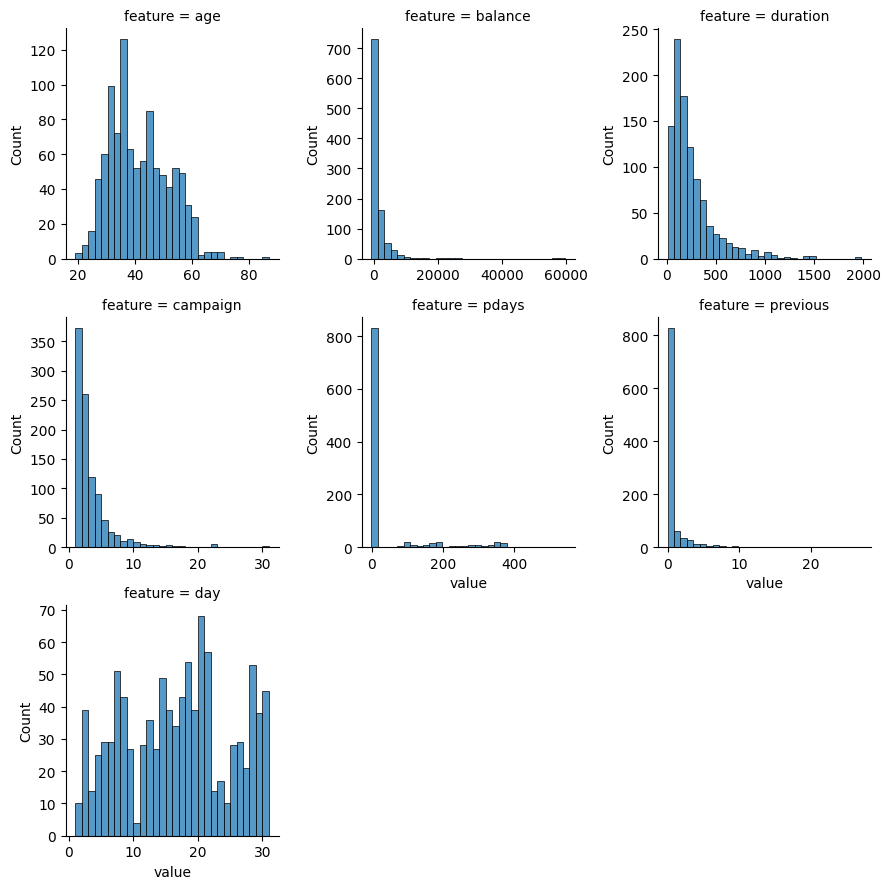

In [21]:
# Plot numeric feature distributions
plot_numeric(sample_data, NUMERIC_FEATURES)


- many skewed distributions, outliers across multiple features.
- visual correlation. I will get AI to check


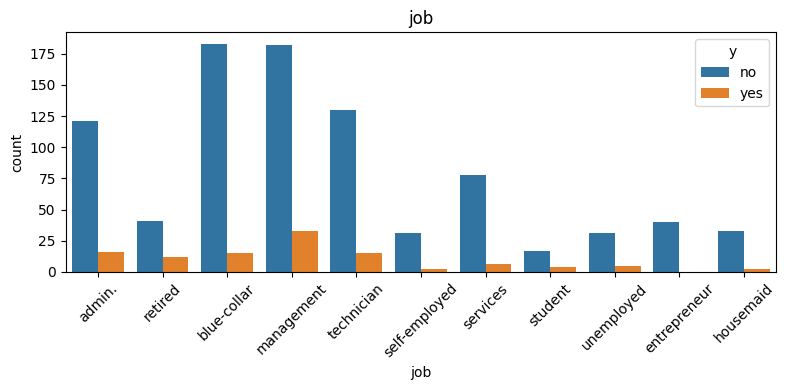

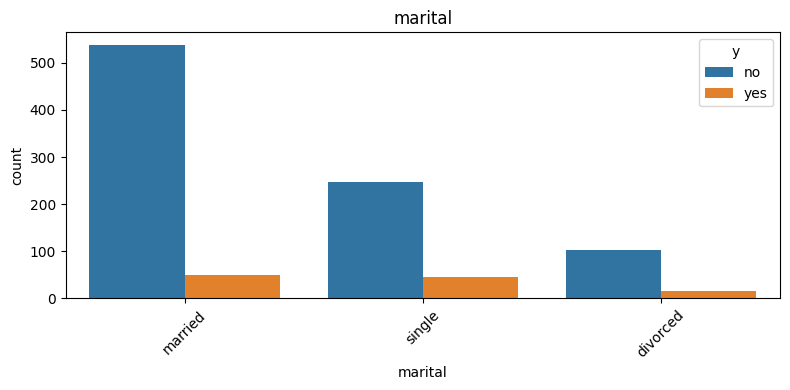

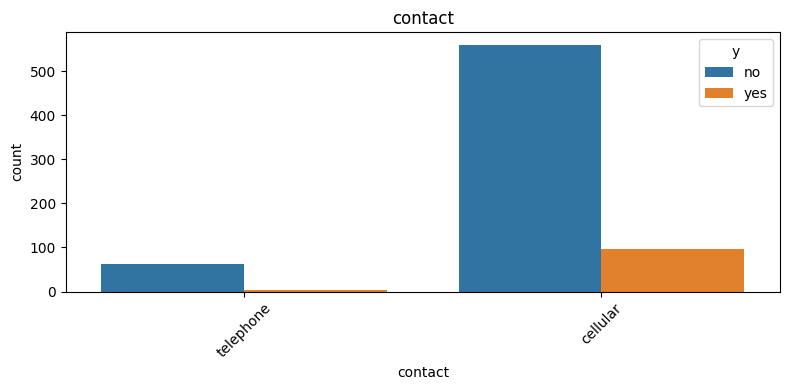

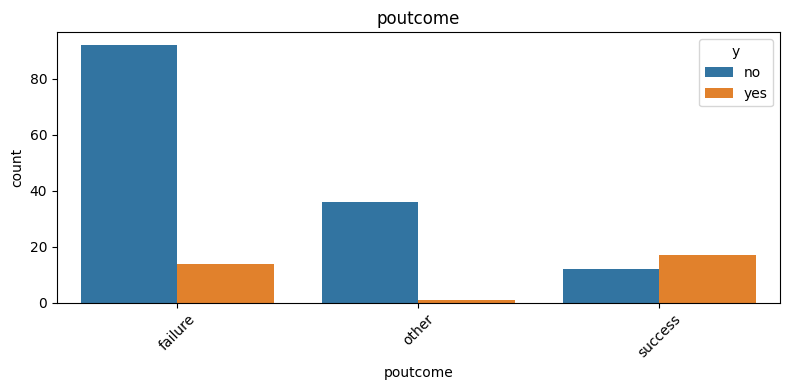

In [22]:
plot_categorical(sample_data, CATEGORICAL_FEATURES)

### What we got 
- ML: binary classification algorithm
- unbalanced target
- dependency between features
- mixed data types
- contains nulls
- all data is assumed to be within the parameters of the data dictionary
- encoding the target

### What we want:

- logistic regression (linear model)
- tree model (rand forest/ XGBoost)

    - both these algorithms deal well with mixed dtypes, classification, and an unbalanced target

In [25]:
def calculate_target_correlation(df: pd.DataFrame, 
                                   numeric_features: list, 
                                   target: str) -> pd.DataFrame:
    """
    Calculate correlation between numeric features and the target variable.
    
    Args:
        df: DataFrame containing the data
        numeric_features: List of numeric column names
        target: Name of the target column
        
    Returns:
        DataFrame with correlations sorted by absolute value
    """
    # Encode target to numeric (yes=1, no=0)
    df_temp = df.copy()
    df_temp[target] = df_temp[target].map({'yes': 1, 'no': 0})
    
    # Calculate correlations
    correlations = df_temp[numeric_features].corrwith(df_temp[target])
    
    # Create results DataFrame
    corr_df = pd.DataFrame({
        'feature': correlations.index,
        'correlation': correlations.values,
        'abs_correlation': correlations.abs().values
    }).sort_values('abs_correlation', ascending=False)
    
    return corr_df.reset_index(drop=True)

In [26]:
# Calculate correlations between numeric features and target
correlations = calculate_target_correlation(sample_data, NUMERIC_FEATURES, TARGET)
correlations

,feature,correlation,abs_correlation
0,duration,0.381954,0.381954
1,campaign,-0.104484,0.104484
2,pdays,0.064876,0.064876
3,previous,0.050585,0.050585
4,day,-0.018543,0.018543
5,balance,0.014667,0.014667
6,age,-0.006911,0.006911


- duration is significantly more correlated than other features. however this is also a leaky feature - you only have this data point after the call. this would be handled with monitoring in a production setting.

## feature eng

pdays and previous :
pdays needs to be transformed as -1 does not represent the same contextual meaning.
pdays -1 should infer 'previous' =0 and poutcome = None (unknown)

In [28]:
def campaign_features(df: pd.DataFrame) -> pd.DataFrame:
    #new binary feature 
    df = df.copy()
    df['first_campaign'] = (df['pdays'] == -1).astype(int)
    # Replace -1 with 0 for pdays 
    #this isnt the best option but it is a quick fix
    df['pdays'] = df['pdays'].replace(-1, 0)
    BINARY_FEATURES.append('first_campaign')
    return df
    #update data dict

In [33]:
sample_data = campaign_features(sample_data)
#sample_data

### encode target

In [34]:
def encode_target(y: pd.Series) -> np.ndarray:
    """
    encode the target variable to binary.
    
    Args:
        y: Target variable with 'yes'/'no' values
        
    Returns:
        Binary encoded array (1 for 'yes', 0 for 'no')
    """
    return (y == 'yes').astype(int).values



In [37]:
target = encode_target(sample_data['y'])

### development for ML

In [38]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    df = campaign_features(df)
    return df

In [48]:
def exclude_features(df: pd.DataFrame) -> pd.DataFrame:
    #remove excluded features (relevant in prod)
    df = df.drop(EXCLUDE_FEATURES, axis=1)
    return df

In [49]:
def prepare_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    #exclude future leaky features
    df = exclude_features(df)
    #drop target and return
    df = df.drop('y', axis=1, errors='ignore')
    return df

### transformers

In [ ]:
def create_preprocessor() -> ColumnTransformer:
    """
    Create a ColumnTransformer for preprocessing the data.
    
    Returns:
        ColumnTransformer for preprocessing the data
    """
    preprocessor = ColumnTransformer(
        transformers=[
            #could get more specific to cater to each category better
            #eg, balance has outliers so RobustScaler() might b better
            ('num', StandardScaler(), NUMERIC_FEATURES),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), CATEGORICAL_FEATURES),
            ('ord', OrdinalEncoder(), ORDINAL_FEATURES), #to keep ordered info
            ('bin', OrdinalEncoder(), BINARY_FEATURES),
        ])
    return preprocessor

In [41]:
def split_data(X: pd.DataFrame, y: pd.Series, \
    test_size: float = 0.2, random_state: int = 77) -> tuple:

    """
    Split the data into training and testing sets.
    
    Args:
        X: Features
        y: Target
        test_size: Proportion of data to allocate to the test set
        random_state: Seed for reproducibility
        
    Returns:
        Tuple of training and testing data
    """
    #stratify to compensate for class imbalance
    return train_test_split(X, y, test_size=test_size, \
    random_state=random_state, stratify=y) 
    

In [43]:
#split_data(sample_data, target)

In [44]:
def save_preprocessor(preprocessor: ColumnTransformer, filepath: str) -> None:
    """
    Save the fitted preprocessor to disk.
    
    Args:
        preprocessor: Fitted ColumnTransformer
        filepath: Path to save the preprocessor
    """
    Path(filepath).parent.mkdir(parents=True, exist_ok=True)
    joblib.dump(preprocessor, filepath)

In [45]:

def load_preprocessor(filepath: str) -> ColumnTransformer:
    """
    Load a fitted preprocessor from disk.
    
    Args:
        filepath: Path to the saved preprocessor
        
    Returns:
        Fitted ColumnTransformer
    """
    return joblib.load(filepath)

In [46]:
def preprocess_for_training(filepath: str) -> tuple:
    """
    Complete preprocessing pipeline for training.
    
    Args:
        filepath: Path to the dataset CSV
        
    Returns:
        Tuple of (X_train, X_test, y_train, y_test, fitted_preprocessor)
    """
    # Load and clean data
    df = load_data(filepath)
    df = clean_data(df)
    
    # Separate features and target
    X = prepare_features(df)
    y = encode_target(df[TARGET])
    
    # Split data
    X_train, X_test, y_train, y_test = split_data(X, y)
    
    # Create and fit preprocessor
    preprocessor = create_preprocessor()
        #fit transform to fit the model
    X_train_processed = preprocessor.fit_transform(X_train)
        #transform to apply the learned parameters on unseen test data
    X_test_processed = preprocessor.transform(X_test)
    
    return X_train_processed, X_test_processed, y_train, y_test, preprocessor

In [51]:
#preprocess_for_training('../../DATA/dataset.csv')